# Desafio evaluado s3: 

## Inferencia de topicos con EM


### Ejercicio 1: Preparar el ambiente de trabajo

* Importe los módulos numpy, pandas, matplotlib, seaborn, glob y os siguiendo las
buenas prácticas. Los últimos dos módulos permitirán realizar la importación de
múltiples archivos dentro de la carpeta dump.

In [1]:
## Basicas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn')

import glob, os

* Para ello genere un objeto que guarde en una lista todos los archivos alojados en
dump utilizando glob.glob y os.getcwd() para extraer las rutas absolutas.
Posteriormente genere un objeto pd.DataFrame que contenga todos los csv.

In [2]:
lista_rutas = glob.glob(os.getcwd()+'/dump/*.csv')

In [3]:
obj_dfs = []
for ruta in lista_rutas:
    obj_dfs.append(pd.read_csv(ruta,
        index_col=None, header=0).drop(columns='Unnamed: 0'))

In [4]:
obj_dfs[0]

,0,1,2,3
0,SIA,pop,Don't Get Me Started,Don't want to be another craze \n How about ra...
1,SIA,pop,I Don't Want To Want You,I like to take you \n Only 'cause I choose \n ...
2,SIA,pop,Onlysee,"You, and you alone \n You, and you alone \n Ha..."
3,SIA,pop,Stories,How can I climb inside you \n The way that you...
4,SIA,pop,Madlove,Your insensitivity is your personality \n A tr...
...,...,...,...,...
106,SIA,pop,Sunshine,My sweet I know that you feel weak \n My sweet...
107,SIA,pop,Underneath The Mistletoe,I've got a crush lalalalalala \n Like a school...
108,SIA,pop,Everyday Is Christmas,Old father time \n You and me and holiday wine...
109,SIA,pop,Underneath The Christmas Lights,Will the snow fall for me Christmas night \n F...


### Ejercicio 2: Matriz de ocurrencias

* Importe la clase CountVectorizer dentro de los módulos
feature_extraction.text de la libreríasklearn.
* Aplique la clase para extraer las 5000 palabras más repetidas en toda la base de
datos.

In [5]:
df_letras = pd.concat(obj_dfs)
df_letras.columns = ['Artist', 'Genre', 'Song', 'Lyrics']
df_letras.sample()

,Artist,Genre,Song,Lyrics
10,The Doors,rock,The End,"Unfortunately, we are not licensed to display ..."


In [6]:
from sklearn.feature_extraction.text import CountVectorizer

In [7]:
cv = CountVectorizer(stop_words='english', max_features=5000)

* Con la clase inicializada,incorpore las letras con el método fit_transform y guarde los resultados en un nuevo objeto.

In [8]:
cv_fit = cv.fit_transform(df_letras['Lyrics'])

In [9]:
words = cv.get_feature_names_out()
word_frequency = cv_fit.toarray().sum(axis=0)
words_freq_df= pd.DataFrame([list(words), list(word_frequency)]).T

In [10]:
word_frequency

array([ 42, 152,  82, ...,  49,  36,  39])

In [11]:
words_freq_df.columns = ['word', 'freq']
words_freq_df

,word,freq
0,000,42
1,10,152
2,100,82
3,11,44
4,12,89
...,...,...
4995,zombies,31
4996,zone,209
4997,zoo,49
4998,zoom,36


In [12]:
df_5000 = words_freq_df.sort_values(by='freq', ascending=False)
df_5000

,word,freq
2483,like,19629
1241,don,17398
2362,know,14962
1847,got,14171
2299,just,13978
...,...,...
3375,ra,31
2666,mattress,31
3796,shakes,31
2646,martyr,31


In [13]:
def word_count_by_genre(vectorizer=CountVectorizer(stop_words='english',ngram_range=(1,2)),
                        df=df_letras, target='Lyrics',
                          genre='hiphop',sort_n=100):
    tmp_vect = vectorizer
    tmp_fit_transform = tmp_vect.fit_transform(df[df['Genre']== genre][target])
    tmp_words = tmp_vect.get_feature_names_out()
    tmp_frequencies = tmp_fit_transform.toarray().sum(axis=0)
    tmp_df = pd.DataFrame([list(tmp_words), list(tmp_frequencies)]).T
    tmp_df.columns = ['words', 'freq']
    tmp_df = tmp_df.sort_values(by='freq', ascending=False).iloc[0:sort_n, :]
    plt.barh(tmp_df['words'], tmp_df['freq'])

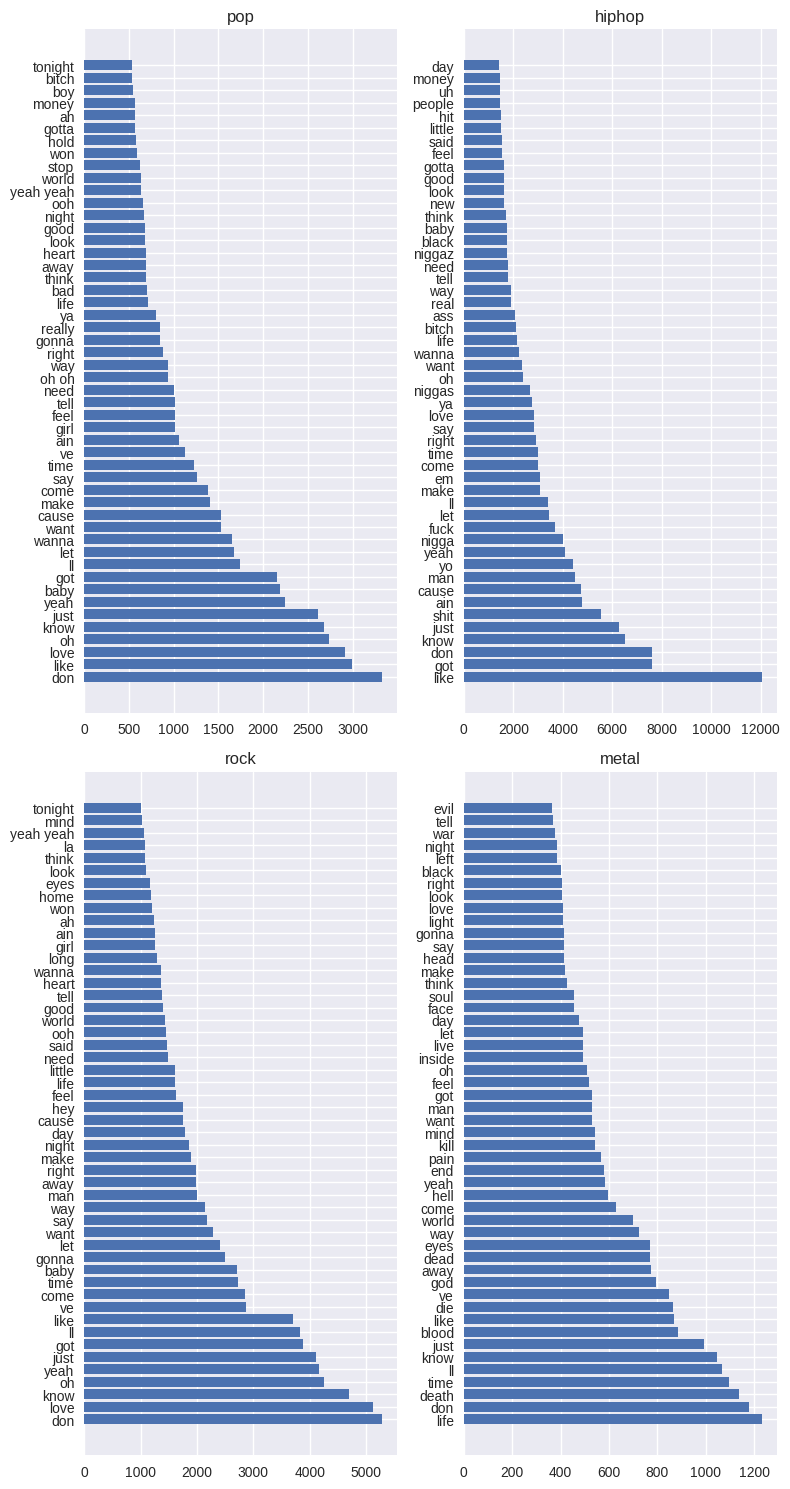

In [14]:
plt.figure(figsize=(8,15))
for index, gen in enumerate(df_letras['Genre'].unique()):
    plt.subplot(2,2,index+1)
    word_count_by_genre(genre=gen, sort_n=50)
    plt.title(gen)
    plt.tight_layout()

## Ejercicio 3: Entrenamiento del Modelo

* Importe sklearn.decomposition.LatentDirichletAllocation y
sklearn.model_selection.GridSearchCV.

In [15]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV

In [16]:
matriz_letras_cv = cv_fit.toarray()
matriz_letras_cv.shape

(9489, 5000)

In [17]:
df_letras.shape

(9489, 4)

* Genere una búsqueda de grilla con los siguientes hiper parámetros:

In [18]:
y = df_letras['Genre']
y

0         pop
1         pop
2         pop
3         pop
4         pop
        ...  
268    hiphop
269    hiphop
270    hiphop
271    hiphop
272    hiphop
Name: Genre, Length: 9489, dtype: object

* Entrene la búsqueda de grilla con las letras en un formato vectorizado con
CountVectorizer.

In [19]:
param = {
    'n_components': [5,10,15],
    'learning_decay': [.7,.5],
}
# sacar el y

In [20]:
get_params = GridSearchCV(LatentDirichletAllocation(learning_method='online',
                                                random_state=1991),
                        param,
                        cv=3,
                        n_jobs=-1,
                        verbose=5,
                        )
get_params.fit(matriz_letras_cv)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 2/3] END learning_decay=0.5, n_components=5;, score=-3138100.813 total time=  32.4s
[CV 3/3] END learning_decay=0.5, n_components=10;, score=-3104810.534 total time=  32.7s
[CV 3/3] END learning_decay=0.5, n_components=5;, score=-3093520.823 total time=  33.7s
[CV 2/3] END learning_decay=0.5, n_components=10;, score=-3155484.834 total time=  33.8s
[CV 1/3] END learning_decay=0.5, n_components=10;, score=-2987012.137 total time=  35.7s
[CV 1/3] END learning_decay=0.5, n_components=5;, score=-2973452.643 total time=  36.6s
[CV 3/3] END learning_decay=0.7, n_components=10;, score=-3099518.899 total time=  38.6s
[CV 1/3] END learning_decay=0.5, n_components=15;, score=-3000553.879 total time=  38.2s
[CV 2/3] END learning_decay=0.7, n_components=5;, score=-3137563.575 total time=  40.0s
[CV 3/3] END learning_decay=0.7, n_components=5;, score=-3089173.745 total time=  40.6s
[CV 2/3] END learning_decay=0.7, n_components=10;, scor

GridSearchCV(cv=3,
             estimator=LatentDirichletAllocation(learning_method='online',
                                                 random_state=1991),
             n_jobs=-1,
             param_grid={'learning_decay': [0.7, 0.5],
                         'n_components': [5, 10, 15]},
             verbose=5)

In [21]:
get_params.best_params_

{'learning_decay': 0.7, 'n_components': 5}

In [22]:
get_params.best_score_

-3067227.116472833

* Finalmente la mejor combinacion de parametros, donde buscamos maximizar score es:
    - <span style="color:Green">{'learning_decay': 0.7, 'n_components': 5}

In [23]:
get_params.cv_results_

{'mean_fit_time': array([39.90056308, 39.31464148, 41.53548487, 32.66686352, 32.48896821,
        25.59522581]),
 'std_fit_time': array([1.51660992, 1.43975642, 1.29638496, 1.75216324, 1.3310109 ,
        7.88274698]),
 'mean_score_time': array([1.33053533, 1.23088233, 1.1460286 , 1.55897951, 1.57856488,
        1.07686853]),
 'std_score_time': array([0.20330186, 0.07419581, 0.02841146, 0.05923625, 0.13209302,
        0.28975492]),
 'param_learning_decay': masked_array(data=[0.7, 0.7, 0.7, 0.5, 0.5, 0.5],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_components': masked_array(data=[5, 10, 15, 5, 10, 15],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'learning_decay': 0.7, 'n_components': 5},
  {'learning_decay': 0.7, 'n_components': 10},
  {'learning_decay': 0.7, 'n_components': 15},
  {'learning_decay': 0.5, 'n_components': 5}

## Ejercicio 4 : Inferencia e Identificación de Tópicos

* En base a la mejor combinación de hiper parámetros, entrene el modelo con la matriz
de atributos de las letras.

In [24]:
best_lda = get_params.best_estimator_
best_lda

LatentDirichletAllocation(learning_method='online', n_components=5,
                          random_state=1991)

* Para identificar de qué se trata cada tópico, necesitamos identificar las principales
15 palabras asociadas con éste. Puede implementar la siguiente línea de código para
identificar las principales palabras en un tópico:

In [25]:
componentes_lda = best_lda.components_
componentes_lda.shape

(5, 5000)

In [26]:
for topic_id, topic_name in enumerate(best_lda.components_):
    print("tópico: {}".format(topic_id + 1))
    print(" ".join([cv.get_feature_names_out()[i] for i in topic_name.argsort()[:-15 - 1: -1]]))

tópico: 1
don know just time want ll say away ve like friends life feel cause make
tópico: 2
man like ll just head dead run kill blood em white eat ya face fucking
tópico: 3
love oh yeah baby come got gonna let ll hey ooh girl night ah know
tópico: 4
like got ain shit know don cause fuck nigga yo just yeah em ya man
tópico: 5
god black death life die soul man ma war hell world light power live lord


* Comente a qué tópicos está asociada cada clase inferida


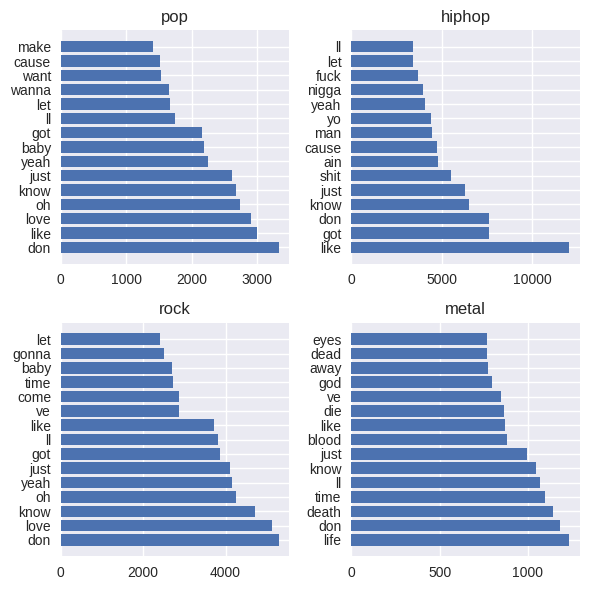

In [27]:
plt.figure(figsize=(6,6))
for index, gen in enumerate(df_letras['Genre'].unique()):
    plt.subplot(2,2,index+1)
    word_count_by_genre(genre=gen, sort_n=15)
    plt.title(gen)
    plt.tight_layout()

* Cada topico esta configurada por la lista de palabras caracteristicas asociadas
* En nuestra data original teniamos 4 generos, sin embargo el modelo nos entrega 4 topicos.
* A grandes razgos y segun lo analizado podriamos inferir de manera intuitiva la cercania a cada genero:
    - topico 1: pop
    - topico 2: nu-metal rap-metal
    - topico 3: rock
    - topico 4: hiphop
    - topico 5: metal


## Ejercicio 5: Identificación de probabilidades

* En base a la información generada, es posible identificar cuales van a ser los géneros
más probables de ocurrir para un artista.
* Para ello necesitamos guardar la probabilidad de cada canción en nuestra base de
datos original. Podemos implementar esto de la siguiente manera:

In [28]:
fit_best_lda = best_lda.transform(matriz_letras_cv)

topics_for_each_doc = pd.DataFrame(
# pasamos esta matriz y la redondeamos en 3 decimales
np.round(fit_best_lda, 3),
# agregamos un índice
index=df_letras.index
)
#agregamos identificadores de columna
topics_for_each_doc.columns = list(map(lambda x: "T: {}".format(x),
range(1, best_lda.n_components + 1)))
# concatenamos las probabilidades de tópico por documento a nuestra
#matriz original
concatenated_df = pd.concat([df_letras, topics_for_each_doc], axis=1)
# argmax en la matriz de tópicos
concatenated_df['highest_topic'] = np.argmax(topics_for_each_doc.values,
axis=1) + 1

In [29]:
concatenated_df.head(5)

,Artist,Genre,Song,Lyrics,T: 1,T: 2,T: 3,T: 4,T: 5,highest_topic
0,SIA,pop,Don't Get Me Started,Don't want to be another craze \n How about ra...,0.827,0.166,0.002,0.002,0.002,1
1,SIA,pop,I Don't Want To Want You,I like to take you \n Only 'cause I choose \n ...,0.985,0.004,0.004,0.004,0.004,1
2,SIA,pop,Onlysee,"You, and you alone \n You, and you alone \n Ha...",0.836,0.087,0.003,0.003,0.071,1
3,SIA,pop,Stories,How can I climb inside you \n The way that you...,0.992,0.002,0.002,0.002,0.002,1
4,SIA,pop,Madlove,Your insensitivity is your personality \n A tr...,0.608,0.059,0.325,0.004,0.004,1


* Genere una matriz de correlaciones entre la probabilidad de tópicos inferidos.
Comente brevemente cuales son las principales asociaciones existentes.


In [30]:
corr_concat_df = concatenated_df.loc[:,'T: 1':'T: 5'].corr()

<AxesSubplot:>

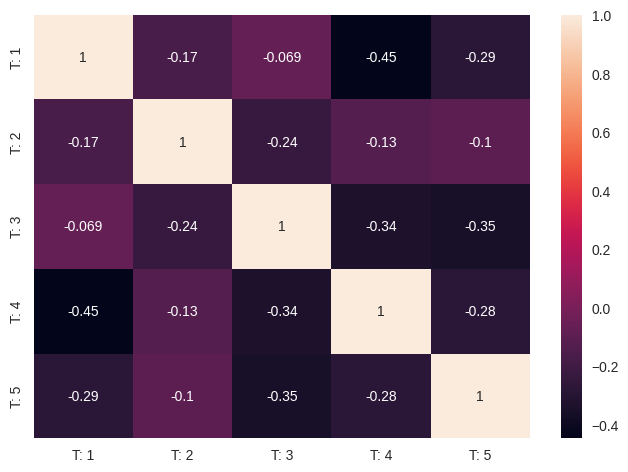

In [31]:
sns.heatmap(corr_concat_df, annot=True)

* Primero notar que todas las correlaciones son negativas, lo cual es de esperar, dado la naturaleza de los datos, en que clasificamos la probabilidad de que la letra de una cancion pertenezca a un topico y no a otro, osea que mientras mas aumenta la probabilidad de un topico los demas disminuyen.
* Dadas las concluciones previas segun el criterio del investigador:
    - topico 1: pop
    - topico 2: nu-metal rap-metal
    - topico 3: rock
    - topico 4: hiphop
    - topico 5: metal
* Observar como T1 con T2 y T3 casi no se correlacionan.
* Por otro lado T1 y T4 se corelacionan en un -0.45, logrando ser la mas alta, mas no lo suficiente como para demostrar una correlacion fuerte.
* Hace sentido que el hiphop y el pop (T1 y T4) sean mas opuestos y muestren una correlacion negativa un poco mas alta, que el pop con el rock (T1 y T3), que muestran no tener ni una relacion el uno con el otro.


In [32]:
data_artista = concatenated_df.loc[:,['Artist', 'Genre', 'T: 1','T: 2','T: 3','T: 4','T: 5']]

In [33]:
data_artista = data_artista.rename(columns={'T: 1':'T1:pop',
    'T: 2':'T2:rap-metal',
    'T: 3':'T3:rock',
    'T: 4':'T4:hiphop',
    'T: 5':'T5:metal'})

In [34]:
data_artista.columns

Index(['Artist', 'Genre', 'T1:pop', 'T2:rap-metal', 'T3:rock', 'T4:hiphop',
       'T5:metal'],
      dtype='object')

In [35]:
vars = ['T1:pop', 'T2:rap-metal', 'T3:rock', 'T4:hiphop',
       'T5:metal']

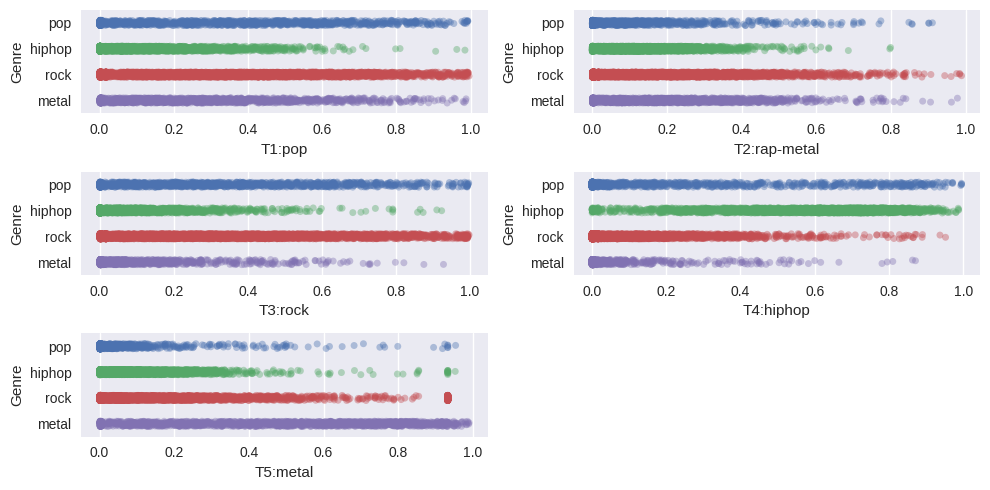

In [36]:
plt.figure(figsize=(10, 5))
for n, col in enumerate(vars):
    plt.subplot(3,2,n+1)
    sns.stripplot(data=data_artista,x=col,y='Genre', hue='Genre',alpha=.4)
    plt.legend('')

plt.tight_layout()

* Con esta nueva base de datos, identifique las probabilidades de pertenencia para un
artista específico.
* Grafique la distribución de las probabilidades para algún artista en específico.

In [41]:
def decribe_artist(df, name):
    data_name= df.loc[df['Artist']==name]
    print(data_name.describe())
    plt.figure(figsize=(10, 5))
    for n, col in enumerate(vars):
        plt.subplot(3,2,n+1)
        sns.stripplot(data=data_name,x=col,y='Genre',alpha=.4)
    plt.tight_layout()


           T1:pop  T2:rap-metal     T3:rock   T4:hiphop    T5:metal
count  493.000000    493.000000  493.000000  493.000000  493.000000
mean     0.159690      0.192359    0.070596    0.516919    0.060523
std      0.156287      0.122485    0.107733    0.206869    0.065425
min      0.000000      0.001000    0.000000    0.001000    0.000000
25%      0.032000      0.097000    0.001000    0.377000    0.012000
50%      0.120000      0.181000    0.027000    0.535000    0.043000
75%      0.242000      0.260000    0.103000    0.678000    0.085000
max      0.985000      0.634000    0.924000    0.947000    0.403000


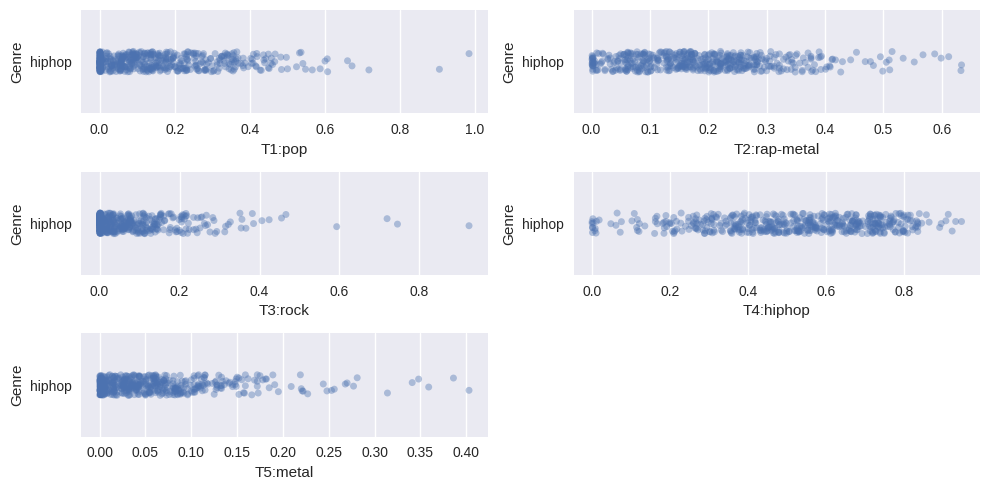

In [42]:
decribe_artist(data_artista, 'Eminem')

* Segun la media de la probabilidad nos indica que coincide con lo analizado previamente, con un valor promedio de .51 en T4 = hiphop
* Como cada 'T' nos implica una columna con todos los datos, podemos interpretar que en T4 es donde encontramos los valores mas altos de probabilidad para toda la muestra. T4 se definio como hiphop